# Hazard assessment for coastal flooding
## Understanding coastal water levels and sea level rise

- A workflow from the CLIMAAX [Handbook](https://handbook.climaax.eu/) and [FLOODS](https://github.com/CLIMAAX/FLOODS) GitHub repository.
- See our [how to use risk workflows](https://handbook.climaax.eu/notebooks/workflows_how_to.html) page for information on how to run this notebook.

## Asessing local coastal water levels using global datasets

In this notebook we will show an example of coastal water level timeseries, understand ranges of water levels and storm surges at the location of interest, and explore the projections of sea level rise. The datasets on water levels will be downloaded from the Climate Data Store.

The following datasets will be used:
- [Global dataset of water level timeseries](https://cds.climate.copernicus.eu/datasets/sis-water-level-change-timeseries-cmip6?tab=overview) based on reanalysis climate data.
- [Global dataset of statistical indicators](https://cds.climate.copernicus.eu/datasets/sis-water-level-change-indicators-cmip6?tab=overview) derived from the water level timeseries.
- IPCC 6th Assessment Report Sea Level Projections available via the [NASA Sea Level Projection Tool](https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool).

The notebook is structured as follows: 
- First we will look at the representative timeseries of water levels and try to understand the typical range of water level and surge levels at a given location.
- Second, we will explore statistics of extreme water levels based on long-term dataset of modelled water levels.
- Third, we will take a look at the latest sea level rise projections to understand the range of expected sea level rise and its uncertainty band.

Please note that in this notebook we make use of a dataset derived from the Global Tides and Surges Model (GTSMv3.0). This model has a resolution of 1.25 km along the European coastlines. It does not replace the need for local modelling and cannot provide high-resolution results that would take into account all features of the local coastal system. We recommend to consult local observation data in order to validate the data shown here before using it in decision-making.

## Preparation work

### Choose the area of interest

We first need to define the location for which we will analyze the water level data. This will be done by providing coordinates of the location of interest, the coordinates are specified in WGS84 coordinates (EPSG:4326). 

In [30]:
loc_coords = [-1.45, 46.1]; areaname = 'La_Rochelle' 

### Load libraries

`````{admonition} Find more info about the libraries used in this notebook here
:class: hint dropdown
In this notebook, we will use the following Python libraries:
- [os](https://docs.python.org/3/library/os.html) - Provides a way to interact with the operating system, allowing the creation of directories and file manipulation.
- [numpy](https://numpy.org/) - A powerful library for numerical computations in Python, widely used for array operations and mathematical functions.
- [xarray](https://docs.xarray.dev/en/stable/) - library for working with labelled multi-dimensional arrays.
- [matplotlib](https://matplotlib.org/) - A versatile plotting library in Python, commonly used for creating static, animated, and interactive visualizations.
- [zipfile](https://docs.python.org/3/library/zipfile.html) - Enables functions to work with ZIP archives.
- [cdsapi](https://pypi.org/project/cdsapi/) - Climate Data Store API.
`````

In [2]:
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cdsapi
import zipfile

### Create the directory structure

In [3]:
# Define the folder for the flood workflow
workflow_folder = 'FLOOD_COASTAL_hazard'

# Check if the workflow folder exists, if not, create it
if not os.path.exists(workflow_folder):
    os.makedirs(workflow_folder)

In [4]:
# Define directories for data and plots within the previously defined workflow folder
data_dir_general = os.path.join(workflow_folder, f'data_general')
data_dir = os.path.join(workflow_folder, f'data_{areaname}')
plot_dir = os.path.join(workflow_folder, f'plots_{areaname}')

if not os.path.exists(data_dir_general):
    os.makedirs(data_dir_general)
if not os.path.exists(data_dir):
    os.makedirs(data_dir)
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

data_dir_wl = os.path.join(data_dir,'waterlevels')
if not os.path.exists(data_dir_wl):
    os.makedirs(data_dir_wl)

### Make a connection with Copernicus Climate Data Store

We will need to download data from the CDS with the API - look at [How to change your API KEY](https://cds.climate.copernicus.eu/how-to-api#install-the-cds-api-token) and copy the key to the variable KEY below.

In [5]:
URL = "https://cds.climate.copernicus.eu/api"
KEY = None   ##### PUT YOUR OWN KEY
cdsapi_client = cdsapi.Client(url=URL, key=KEY)

## Access and view a sample of water level timeseries

We first want to understand what the typical water level timeseries at our location look like. The water level is composed of mean water level, tidal water levels and surge levels, where the latter are caused by the effect of the atmospheric conditions and can change depending on the weather conditions.

We will retrieve the timeseries of daily maximum water levels and daily maximum surge levels for one year (2015).

In [7]:
# retrieve a sample of the timeseries of water levels
year = 2015
filename = os.path.join(data_dir_general,f'water_levels_{year}.zip')

if not os.path.exists(filename):
    cdsapi_client.retrieve(
        'sis-water-level-change-timeseries-cmip6',
        {
            'variable': ['total_water_level', 'storm_surge_residual'],
            'experiment': 'reanalysis',
            'temporal_aggregation': ['daily_maximum'],
            'year': [year],
            'month': ['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'],
            'format': 'zip',
        },
        filename)

The water levels were retrieved as a .zip file. We will unzip it now:

In [8]:
# Extract from zip file
with zipfile.ZipFile(filename, 'r') as zObject:
    zObject.extractall(path=data_dir_wl)
os.remove(filename); del filename

The water level data was downloaded as monthly files. We can open the full timeseries of total water levels and surge levels using *xarray*:

In [78]:
twl = xr.open_mfdataset(os.path.join(data_dir_wl,f'reanalysis_waterlevel_dailymax_*.nc'), decode_coords='all')
surge = xr.open_mfdataset(os.path.join(data_dir_wl,f'reanalysis_surge_dailymax_*.nc'), decode_coords='all')

We can view the contents of the water level dataset:

In [79]:
twl

<xarray.Dataset>
Dimensions:               (time: 365, stations: 43119)
Coordinates:
  * time                  (time) datetime64[ns] 2015-01-01 ... 2015-12-31
    station_x_coordinate  (stations) float64 dask.array<chunksize=(43119,), meta=np.ndarray>
    station_y_coordinate  (stations) float64 dask.array<chunksize=(43119,), meta=np.ndarray>
  * stations              (stations) uint16 0 1 2 3 ... 43730 43731 43732 43733
Data variables:
    waterlevel            (time, stations) float32 dask.array<chunksize=(31, 43119), meta=np.ndarray>
Attributes: (12/35)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_totalwaterlevels
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         Daily timeseries of total water levels
    ...                            ...
    time_coverage_start:           2015-01-01 00:00:00
    time_coverage_end:             2015-01-31 00:00:00
    experiment:                    reanalysis
    date_modified:                 2021-05-06 22:30:19.085903 UTC
    contact:                       Please contact Copernicus User Support on ...
    history:                       This is version 1 of the dataset

The dataset contains daily maximum values of water levels for over 43000 stations globally. We now need to extract only the location that we are interested in, by looking for the correct coordinates.

In [80]:
# load the dataset of coordinates in memory
coords = twl
coords = coords.drop_vars({'waterlevel','time'})
coords.load();

In [81]:
# Find closest location to the location of interest
abslat = np.abs(coords.station_x_coordinate-loc_coords[0])
abslon = np.abs(coords.station_y_coordinate-loc_coords[1])
c = np.maximum(abslon, abslat)

ind = np.where(c == np.min(c)); ind=ind[0]
station_id = coords['stations'][ind]

In [82]:
# Keep only the water level and surge data at the location of interest in variable twl:
twl = twl.sel(stations=station_id)
surge = surge.sel(stations=station_id)

We can now plot the water level timeseries. Note that the water level is the daily maximum, showing us the upper values of the water levels for each day of the year. This timeseries also already includes sea level rise. The water levels are defined relative to mean sea level in 1986-2005.

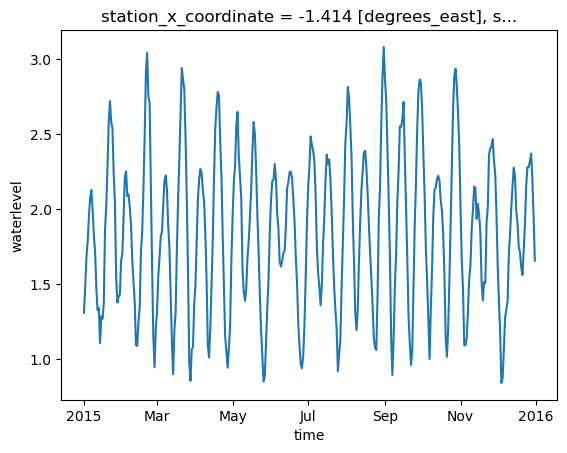

In [36]:
twl['waterlevel'].plot()

And we can plot the daily maximum surge levels:

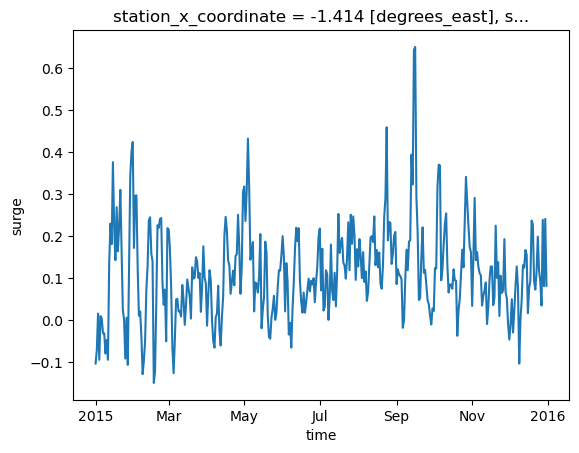

In [37]:
surge['surge'].plot()

The plots above help us understand the upper range of water levels at the location of interest, mainly dominated by the tidal fluctuations, but with a component of surge that varies throughout the year. Surge levels can increase significantly during storms, and data for one year is not representative to derive the upper limit. 

## Access and view water level statistics

On CDS we can also access a related dataset with water level statistics, computed over the period of 1979-2018 and based on reanalysis (ERA5) atmospheric data. This dataset allows us to estimate the extreme water levels over a longer period of time. We will retrieve the 5-year and 100-year values for the total water levels.

In [38]:
# Define zip file's absolute path
zip_path = os.path.join(data_dir_wl,'extreme_total_sea_level.zip')

cdsapi_client.retrieve(
    'sis-water-level-change-indicators-cmip6',
    {
        'variable': ['total_water_level'],
        'derived_variable': ['absolute_value'],
        'product_type': ['reanalysis'],
        'statistic': ['100_year', '5_year'],
        'confidence_interval': ['best_fit'],
        'period': ['1985_2014'],
        'format': 'zip',
    },
    zip_path)

In [39]:
# Extract data from zip
with zipfile.ZipFile(zip_path, 'r') as zObject:
    zObject.extractall(path=data_dir_wl)
os.remove(zip_path); del zip_path

We can open the datasets of extreme water levels for the 5-year and 100-year extreme values:

In [40]:
ewl_100yr = xr.open_mfdataset(os.path.join(data_dir_wl,f'reanalysis_waterlevel_actual-value_1985-2014_rp100*.nc'))
ewl_5yr = xr.open_mfdataset(os.path.join(data_dir_wl,f'reanalysis_waterlevel_actual-value_1985-2014_rp5*.nc'))

These datasets also contain the data for over 43000 stations. We will select only the station in the region of interest:

In [41]:
ewl_100yr = ewl_100yr.sel(stations=station_id)
ewl_5yr = ewl_5yr.sel(stations=station_id)

In [42]:
ewl_100yr.load()
ewl_5yr.load()

<xarray.Dataset>
Dimensions:                  (stations: 1)
Coordinates:
  * stations                 (stations) uint16 41053
    station_x_coordinate     (stations) float64 -1.414
    station_y_coordinate     (stations) float64 46.08
Data variables:
    return_mean_water_level  (stations) float64 3.53
Attributes: (12/34)
    Conventions:                   CF-1.6
    featureType:                   timeSeries
    id:                            GTSMv3_extreme_value_analysis
    naming_authority:              https://deltares.nl/en
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    title:                         return values for water levels
    ...                            ...
    geospatial_vertical_max:       10.032
    geospatial_vertical_units:     m
    geospatial_vertical_positive:  up
    time_coverage_start:           1985
    time_coverage_end:             2014
    experiment:

Now we can check the estimated values of the extreme water levels:

In [43]:
print(f'Extreme water levels for the 5-year return period are estimated to be {ewl_5yr.return_mean_water_level.values[0]:.1f} m above MSL')
print(f'Extreme water levels for the 100-year return period are estimated to be {ewl_100yr.return_mean_water_level.values[0]:.1f} m above MSL')

Extreme water levels for the 5-year return period are estimated to be 3.5 m above MSL
Extreme water levels for the 100-year return period are estimated to be 4.2 m above MSL


**Important:** these water levels do not include the effect of sea level rise. The values are computed relative the mean sea level in the middle of the modelled period (1979-2018, based on detrended timeseries), i.e. ca 2000. Sea level rise that is added to the mean sea level on top of this reference level needs to be added to the extreme sea levels to obtain an esimate of water level extremes in the future. 

## Check the sea level rise projections

Sea level rise contributes to rising water levels and to rising coastal flood risk. Sea level rises at a different rate in different regions. You can explore the sea level rise projections for your location of interest using the [NASA Sea Level Projection Tool](https://sealevel.nasa.gov/ipcc-ar6-sea-level-projection-tool).

Please go to the tool above and navigate to the nearest data point to your location of interest. Select "Total Sea Level" in the menu and select a climate scenario (e.g. SSP3-7.0). After pressing on the button "Global projection" you can view the projected sea level rise for this location up to 2150.

Some questions to consider:
 - How will the sea level change between now and 2050 (or 2100)?
 - What is the effect of different climate scenarios on this change?
 - What is the baseline level used in the projection?
 - How does the sea level rise compare to the extreme water levels estimated earlier in this notebook?

## Contributors

Applied research institute Deltares (The Netherlands). 

Authors of the workflow: 
Natalia Aleksandrova

References:
1.	Muis, S., Apecechea, M. I., Dullaart, J., ... & Verlaan, M. (2020). A High-resolution global dataset of extreme sea levels, tides, and storm surges, including future projections. Frontiers in Marine Science, doi:10.3389/fmars.2020.00263 
2.  Muis, S. et al (2023). Global projections of storm surges using high-resolution CMIP6 climate models. Earth`s Future, https://doi.org/10.1029/2023EF003479